In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import datetime
import csv
import os
import re

In [2]:
!rm -rf data
!scp -r Neo:~/odds-monitoring/data .

ncaaf_odds_vsin_20240928_0723.json            100%   64KB   4.7MB/s   00:00    
nfl_odds_vsin_20240928_0732.json              100%   13KB   1.2MB/s   00:00    
nfl_odds_vsin_20240928_0227.json              100%   13KB   1.2MB/s   00:00    
ufc_odds_vsin_20240928_0432.json              100%   21KB   1.4MB/s   00:00    
ncaaf_odds_vsin_20240928_0236.json            100%   64KB   4.8MB/s   00:00    
ncaaf_odds_vsin_20240928_0518.json            100%   64KB   4.5MB/s   00:00    
nfl_odds_vsin_20240928_0159.json              100%   13KB   1.2MB/s   00:00    
ncaaf_odds_vsin_20240928_0148.json            100%   64KB   5.8MB/s   00:00    
nfl_odds_vsin_20240928_0509.json              100%   13KB   1.6MB/s   00:00    
ufc_odds_vsin_20240928_0520.json              100%   21KB   2.2MB/s   00:00    
ncaaf_odds_vsin_20240928_0324.json            100%   64KB   4.5MB/s   00:00    
nfl_odds_vsin_20240928_0335.json              100%   13KB   1.5MB/s   00:00    
nfl_odds_vsin_20240928_0620.json        

In [3]:
!scp -r Neo:~/data-bak-nfl .

nfl_odds_vsin_20240927_1832.json              100%   13KB   1.0MB/s   00:00    
nfl_odds_vsin_20240927_0720.json              100%   14KB   1.2MB/s   00:00    
nfl_odds_vsin_20240927_1131.json              100%   13KB   1.0MB/s   00:00    
nfl_odds_vsin_20240927_1424.json              100%   13KB   1.3MB/s   00:00    
nfl_odds_vsin_20240926_1746.json              100%   14KB   1.2MB/s   00:00    
nfl_odds_vsin_20240927_0235.json              100%   14KB   1.3MB/s   00:00    
nfl_odds_vsin_20240927_2208.json              100%   13KB   1.2MB/s   00:00    
nfl_odds_vsin_20240927_2121.json              100%   13KB   1.1MB/s   00:00    
nfl_odds_vsin_20240926_2243.json              100%   14KB   1.2MB/s   00:00    
nfl_odds_vsin_20240926_2306.json              100%   14KB   1.2MB/s   00:00    
nfl_odds_vsin_20240927_0059.json              100%   14KB   1.1MB/s   00:00    
nfl_odds_vsin_20240927_0409.json              100%   14KB   1.3MB/s   00:00    
nfl_odds_vsin_20240927_1648.json        

In [ ]:
### NFL ###

# Configure Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run Chrome in headless mode

# Initialize the Chrome WebDriver with the options
driver = webdriver.Chrome(options=chrome_options)

# Navigate to the URL
url = 'https://data.vsin.com/nfl/vegas-odds-linetracker/'
driver.get(url)

try:
    # Wait for the table to be present
    table_xpath = '/html/body/div[6]/div[2]/div/div[3]/div/div/div/div[2]/b/div[2]/table'
    table = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, table_xpath))
    )

    # Get all immediate child elements of the table (both thead and tbody)
    table_children = table.find_elements(By.XPATH, './*')

    # Initialize an empty list to hold all rows of data
    data = []

    # Initialize current column names as empty
    column_names = []

    # Iterate over each child element of the table
    for child in table_children:
        if child.tag_name.lower() == 'thead':
            # Extract column names from the header row
            header_cells = child.find_elements(By.XPATH, './tr/th')
            column_names = [cell.text.strip() for cell in header_cells]
            # Handle empty header names
            column_names = [name if name else f"Column{index+1}" for index, name in enumerate(column_names)]
        elif child.tag_name.lower() == 'tbody':
            # Use the current column names to extract data
            rows = child.find_elements(By.TAG_NAME, "tr")
            for row in rows:
                cells = row.find_elements(By.TAG_NAME, "td")
                cell_data = [cell.text.strip() for cell in cells]
                # Only add row if there is data
                if cell_data:
                    # Match the number of columns in data with column names
                    if len(cell_data) != len(column_names):
                        # Adjust cell_data or column_names if necessary
                        max_length = max(len(cell_data), len(column_names))
                        cell_data.extend([None] * (max_length - len(cell_data)))
                        column_names.extend([f"ExtraColumn{index+1}" for index in range(len(column_names), max_length)])
                    # Create a dictionary using column names as keys
                    row_data = {column_names[index]: value for index, value in enumerate(cell_data)}
                    data.append(row_data)
        else:
            # Other types of elements, skip or handle if needed
            pass

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Close the WebDriver
    driver.quit()

# Generate a timestamp
current_time = datetime.datetime.now()
# timestamp = current_time.strftime("%Y%m%d_%H%M%S")
# timestamp = current_time.strftime("%Y%m%d_%H%M")
timestamp = current_time.strftime("%Y%m%d_%H%M")

# Write the data to a JSON file with timestamp in the filename
filename = f'data/nfl_odds_vsin_{timestamp}.json'
with open(filename, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"Data has been saved to {filename}")

In [ ]:
# Print all games in 1 file

# Load the JSON file from the data directory
with open('data/nfl_odds_vsin_20240926_1456.json') as f:
    games = json.load(f)

# Function to print detailed game information in one line for each sportsbook
def print_game_info(game):
    # Extract the second column name (day and matchup)
    day_and_matchup = list(game.keys())[1]  # Extract the second column name (which contains the date)
    teams = game[day_and_matchup].replace('\n', ' ').replace('Splits', '').strip()  # Remove "Splits" from the teams
    game_time = game['Time'].replace('Splits', '').replace('\n', '').strip()
    print(f"Game Day: {day_and_matchup} | Game Time: {game_time}")
    print(f"Matchup: {teams}\n")
    
    for sportsbook, line in game.items():
        if sportsbook not in ["Time", day_and_matchup]:  # Exclude time and matchup keys
            # Combine the sportsbook and its line into one line
            print(f"\033[1m{sportsbook}:\033[0m {line.replace('\n', ' ')}")
    print('-' * 50)

for game in games[:]:
    print_game_info(game)

# # Print the first 3 games
# print("First 3 Games:")
# for game in games[:3]:
#     print_game_info(game)

# # Print the last 3 games
# print("\nLast 3 Games:")
# for game in games[-3:]:
#     print_game_info(game)

In [ ]:
# Detect odds movement

# Function to dynamically load JSON files based on timestamps
def load_files(directory):
    # Use regex to extract datetime from filenames (assuming filenames follow the same pattern)
    files = [f for f in os.listdir(directory) if re.match(r'nfl_odds_vsin_\d{8}_\d{4}\.json', f)]
    # Sort files by datetime in the filename
    files.sort(key=lambda x: re.findall(r'(\d{8}_\d{4})', x)[0])
    return files

# Function to format odds (to deal with multiline strings for favorite/underdog odds)
def format_odds(odds):
    return odds.replace("\n", " | ")

# Function to compare odds between two datasets and include the date in the output
# Function to compare odds between two datasets and include the date in the output
def detect_odds_movement(odds_before, odds_after):
    movements = []
    
    # Loop through games in odds_before
    for game_before, game_after in zip(odds_before, odds_after):
        if game_before['Time'] == game_after['Time']:  # Match games by time
            
            # Extract the date from the second column (column name)
            game_date_column_name = list(game_before.keys())[1]  # The actual column name for the date
            
            # Compare odds from different sportsbooks
            for key in game_before:
                if key not in ["Time", game_date_column_name] and key in game_after:
                    if game_before[key] != game_after[key]:  # Check if odds have changed
                        movements.append({
                            'game_time': game_before['Time'],
                            'game_date_column_name': game_date_column_name,  # Save the actual column name
                            'game_date_value': game_before[game_date_column_name],  # Save the value of the date column
                            'sportsbook': key,
                            'odds_before': format_odds(game_before[key]),
                            'odds_after': format_odds(game_after[key])
                        })
    return movements

# Directory containing the odds files
directory = 'data/'

# Load and sort files
files = load_files(directory)

# Loop through consecutive files and compare odds
for i in range(len(files) - 1):
    file1 = files[i]
    file2 = files[i + 1]
    
    with open(os.path.join(directory, file1)) as f1, open(os.path.join(directory, file2)) as f2:
        odds_before = json.load(f1)
        odds_after = json.load(f2)
    
    # Detect movements between consecutive files
    odds_movements = detect_odds_movement(odds_before, odds_after)
    
    # Output movements
    if odds_movements:
        print(f"\nODDS MOVEMENT DETECTED {file1} and {file2}:\n")
        for movement in odds_movements:
            # print(f"Game Time: {movement['game_time']}")
            # game_date_value = game_date_value.strip(' ')
            print(f"Game Date: {movement['game_date_column_name']}")
            print(f"Matchup: {movement['game_date_value'].replace('\n', ' vs').strip()}")
            print(f"Sportsbook: {movement['sportsbook']}")
            print(f"Odds before: {movement['odds_before']}")
            print(f"Odds after: {movement['odds_after']}")
            print("")
    else:
        # print(f"No odds movement detected between {file1} and {file2}.")
        pass

In [59]:
# Saving to csv ^

# Function to dynamically load JSON files based on timestamps
def load_files(directory):
    files = [f for f in os.listdir(directory) if re.match(r'nfl_odds_vsin_\d{8}_\d{4}\.json', f)]
    files.sort(key=lambda x: re.findall(r'(\d{8}_\d{4})', x)[0])
    return files

# Function to format odds
def format_odds(odds):
    return odds.replace("\n", " | ")

# Function to compare odds between two datasets
def detect_odds_movement(odds_before, odds_after):
    movements = []
    
    for game_before, game_after in zip(odds_before, odds_after):
        if game_before['Time'] == game_after['Time']:
            game_date_column_name = list(game_before.keys())[1]  # Assuming the second key is the date
            
            for key in game_before:
                if key not in ["Time", game_date_column_name] and key in game_after:
                    if game_before[key] != game_after[key]:
                        movements.append({
                            'game_time': game_before['Time'],  # Game time is stored
                            'game_date_column_name': game_date_column_name,
                            'game_date_value': game_before[game_date_column_name],
                            'sportsbook': key,
                            'odds_before': format_odds(game_before[key]),
                            'odds_after': format_odds(game_after[key])
                        })
    return movements

# Directory containing the odds files
directory = 'data/'

# Load and sort files
files = load_files(directory)

# List to hold all detected movements for CSV
all_movements = []

# Loop through consecutive files and compare odds
for i in range(len(files) - 1):
    file1 = files[i]
    file2 = files[i + 1]
    
    with open(os.path.join(directory, file1)) as f1, open(os.path.join(directory, file2)) as f2:
        odds_before = json.load(f1)
        odds_after = json.load(f2)
    
    # Detect movements between consecutive files
    odds_movements = detect_odds_movement(odds_before, odds_after)
    
    if odds_movements:
        for movement in odds_movements:
            all_movements.append({
                'file1': file1,
                'file2': file2,
                'game_date': movement['game_date_column_name'],  # Save the matchup column name
                'game_time': movement['game_time'],  # Use game_time directly
                'matchup': f"{movement['game_date_value'].replace('\n', ' vs').strip()}",
                'sportsbook': movement['sportsbook'],
                'odds_before': movement['odds_before'],
                'odds_after': movement['odds_after']
            })
    else:
        print(f"No odds movement detected between {file1} and {file2}.")

# Save movements to a CSV file
csv_file_path = 'data/odds_movements.csv'
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['file1', 'file2', 'game_date', 'game_time', 'matchup', 'sportsbook', 'odds_before', 'odds_after']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()  # Write the header
    for movement in all_movements:
        writer.writerow(movement)  # Write each movement

print(f"Odds movements saved to {csv_file_path}")


# CLEANING CSV # 
csv_file_path = 'data/odds_movements.csv'  # Adjust the path if needed
df = pd.read_csv(csv_file_path)
invalid_before_mask = pd.to_numeric(df['odds_before'].str.split(' ').str[0], errors='coerce').isna()
# df.loc[invalid_before_mask, 'odds_before'] = df.loc[invalid_before_mask, 'odds_after']
df.loc[invalid_before_mask, 'odds_before'] = 'open'

# Extract the spread number from 'odds_before' and 'odds_after' after the copy
# df['spread_before'] = pd.to_numeric(df['odds_before'].str.split(' ').str[0], errors='coerce')
# df['spread_after'] = pd.to_numeric(df['odds_after'].str.split(' ').str[0], errors='coerce')

output_csv_file_path = 'data/odds_movements.csv'  # Change the file name if needed
df.to_csv(output_csv_file_path, index=False)
print(f"Updated CSV saved to {output_csv_file_path}")

No odds movement detected between nfl_odds_vsin_20240926_1458.json and nfl_odds_vsin_20240926_1500.json.
No odds movement detected between nfl_odds_vsin_20240926_1504.json and nfl_odds_vsin_20240926_1506.json.
No odds movement detected between nfl_odds_vsin_20240926_1506.json and nfl_odds_vsin_20240926_1508.json.
No odds movement detected between nfl_odds_vsin_20240926_1508.json and nfl_odds_vsin_20240926_1510.json.
No odds movement detected between nfl_odds_vsin_20240926_1512.json and nfl_odds_vsin_20240926_1514.json.
No odds movement detected between nfl_odds_vsin_20240926_1514.json and nfl_odds_vsin_20240926_1516.json.
No odds movement detected between nfl_odds_vsin_20240926_1516.json and nfl_odds_vsin_20240926_1518.json.
No odds movement detected between nfl_odds_vsin_20240926_1518.json and nfl_odds_vsin_20240926_1520.json.
No odds movement detected between nfl_odds_vsin_20240926_1520.json and nfl_odds_vsin_20240926_1522.json.
No odds movement detected between nfl_odds_vsin_2024092

In [85]:
!open data/odds_movements.csv

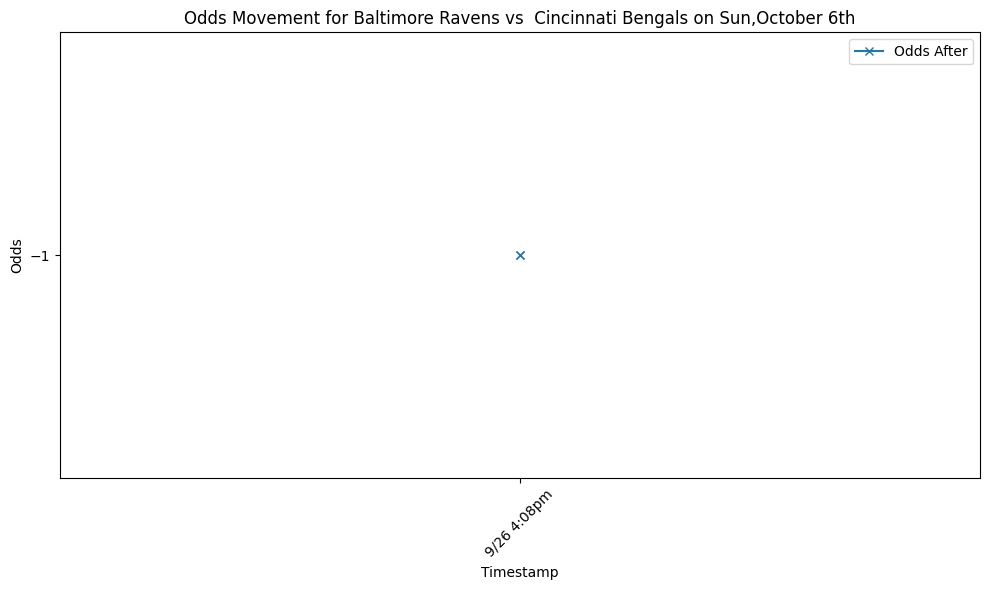

Timestamps for Baltimore Ravens vs  Cincinnati Bengals on Sun,October 6th:
  timestamp
9/26 4:08pm
9/26 4:08pm



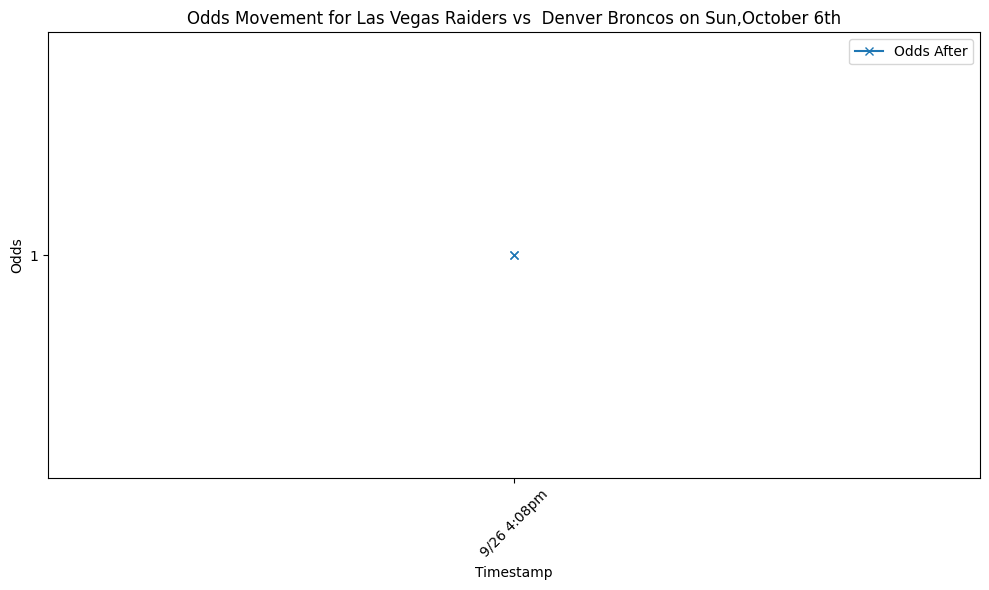

Timestamps for Las Vegas Raiders vs  Denver Broncos on Sun,October 6th:
  timestamp
9/26 4:08pm
9/26 4:08pm



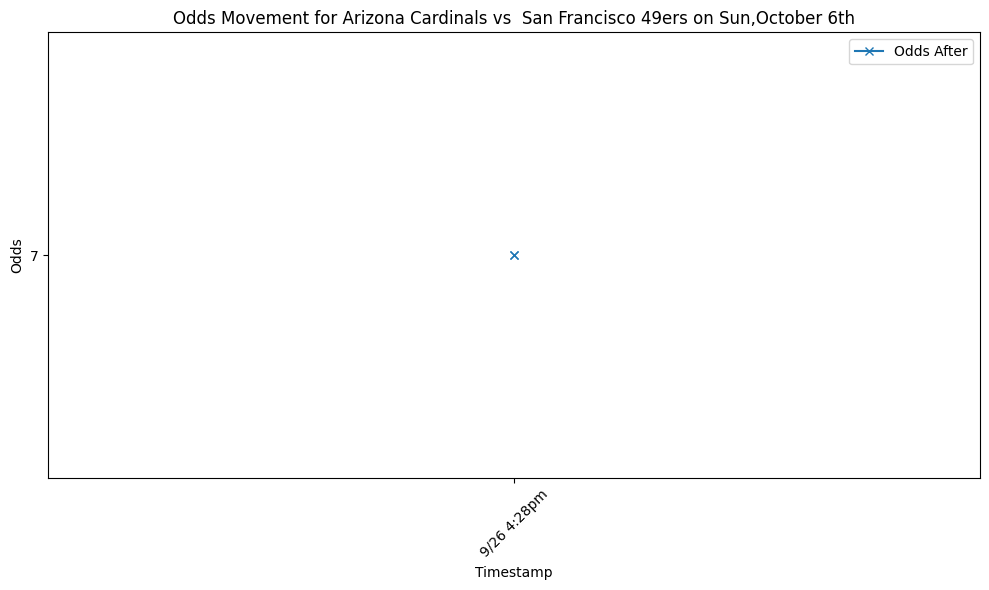

Timestamps for Arizona Cardinals vs  San Francisco 49ers on Sun,October 6th:
  timestamp
9/26 4:28pm
9/26 4:28pm



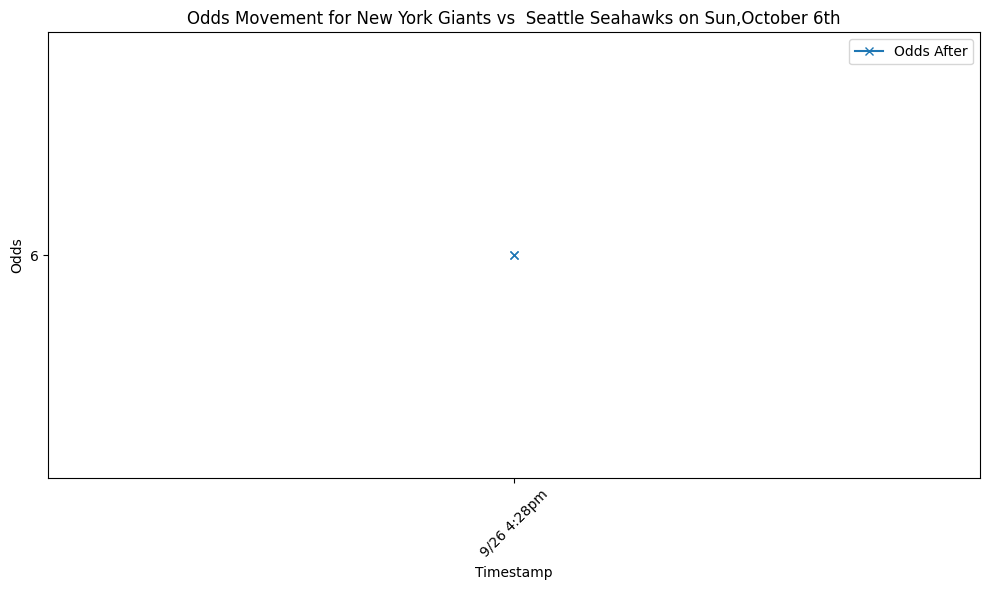

Timestamps for New York Giants vs  Seattle Seahawks on Sun,October 6th:
  timestamp
9/26 4:28pm
9/26 4:28pm
9/26 8:23pm



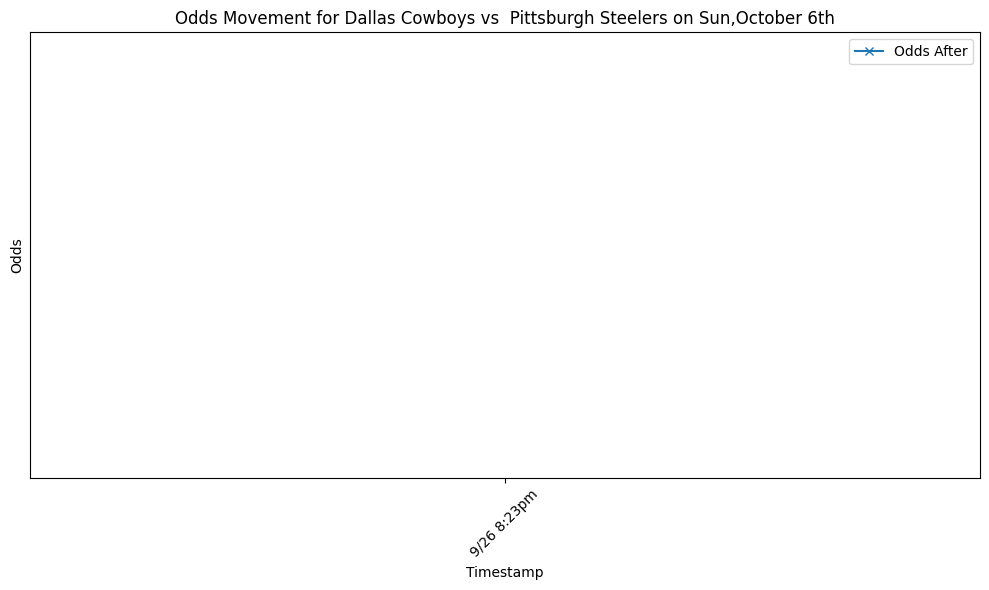

Timestamps for Dallas Cowboys vs  Pittsburgh Steelers on Sun,October 6th:
  timestamp
9/26 8:23pm



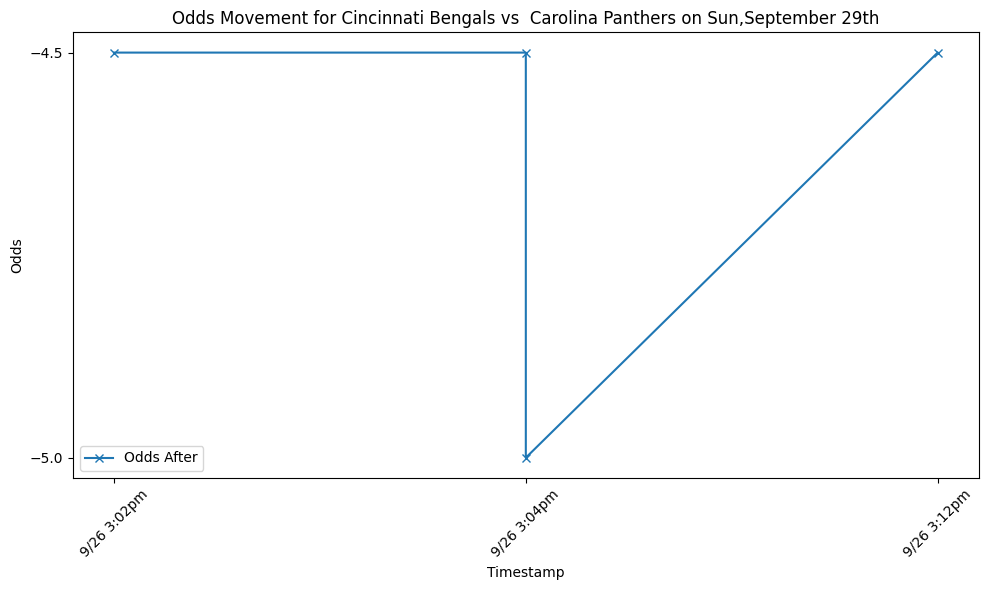

Timestamps for Cincinnati Bengals vs  Carolina Panthers on Sun,September 29th:
  timestamp
9/26 3:02pm
9/26 3:04pm
9/26 3:04pm
9/26 3:12pm



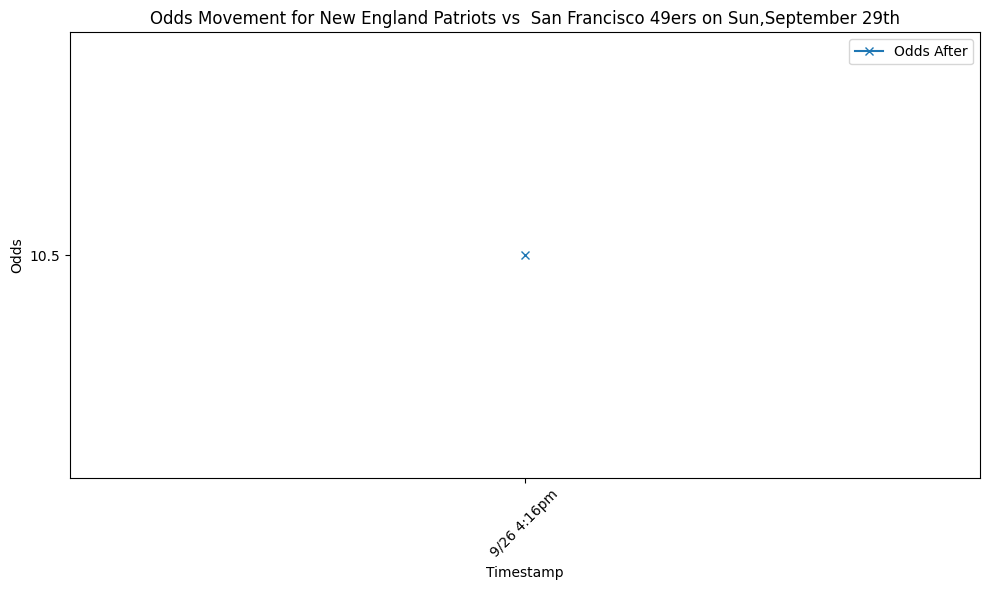

Timestamps for New England Patriots vs  San Francisco 49ers on Sun,September 29th:
  timestamp
9/26 4:16pm



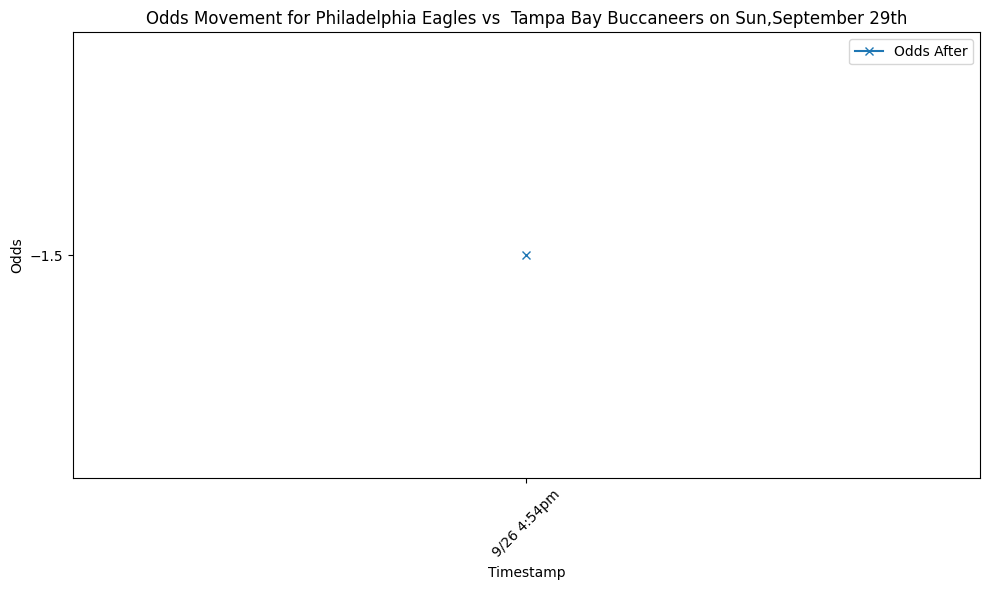

Timestamps for Philadelphia Eagles vs  Tampa Bay Buccaneers on Sun,September 29th:
  timestamp
9/26 4:54pm



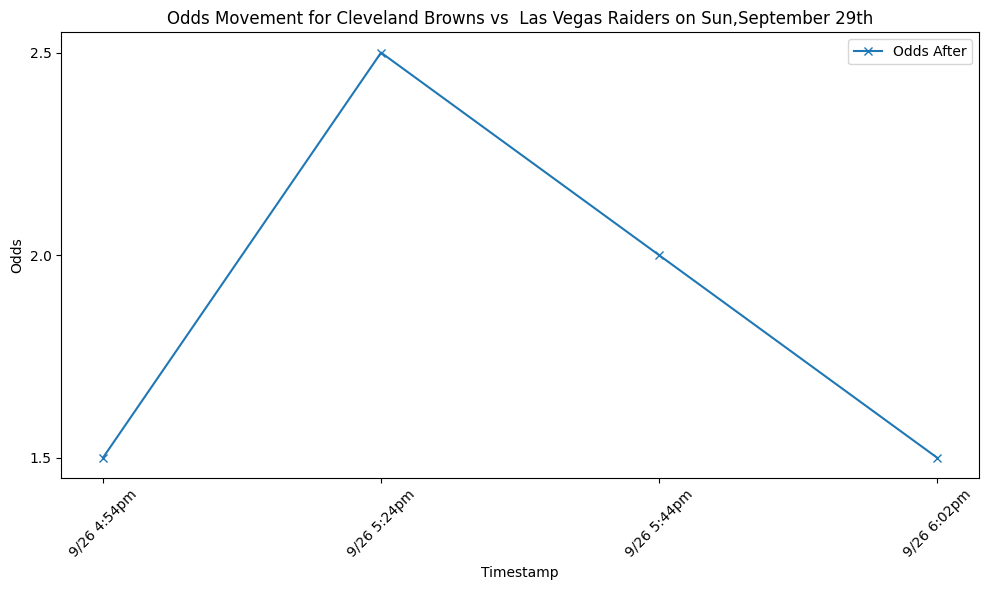

Timestamps for Cleveland Browns vs  Las Vegas Raiders on Sun,September 29th:
  timestamp
9/26 4:54pm
9/26 5:24pm
9/26 5:44pm
9/26 6:02pm



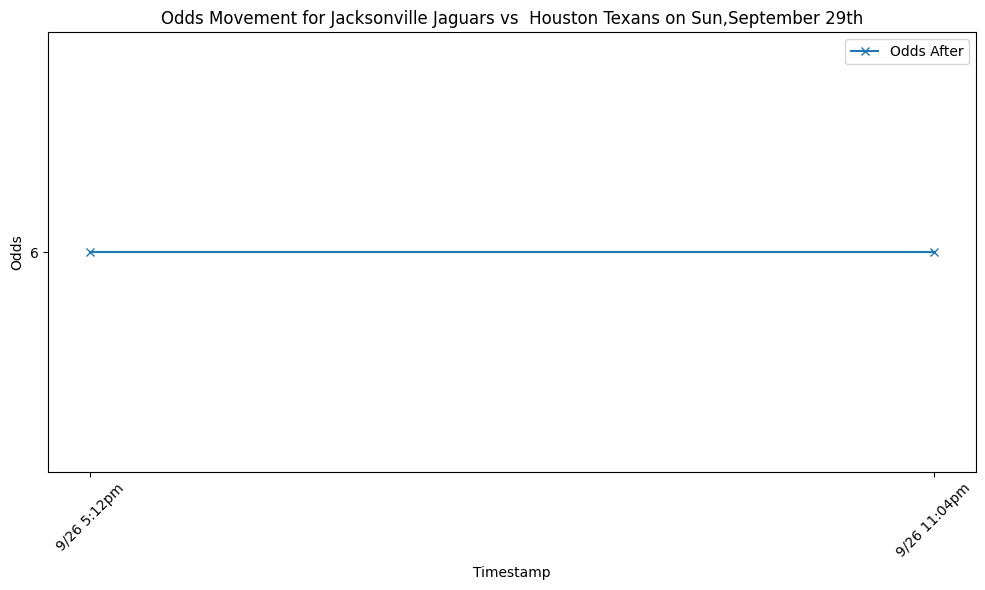

Timestamps for Jacksonville Jaguars vs  Houston Texans on Sun,September 29th:
   timestamp
 9/26 5:12pm
9/26 11:04pm



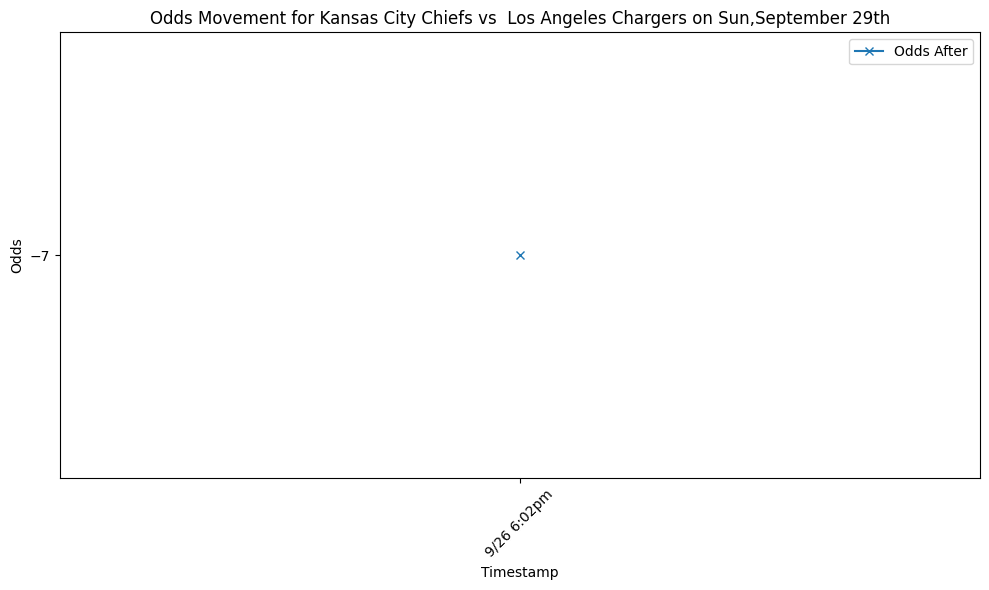

Timestamps for Kansas City Chiefs vs  Los Angeles Chargers on Sun,September 29th:
  timestamp
9/26 6:02pm



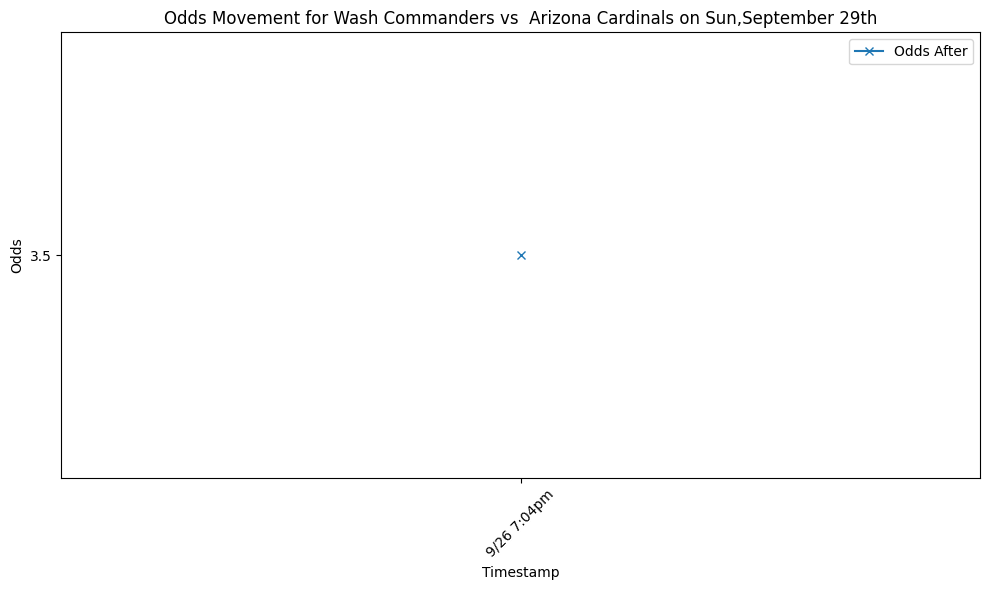

Timestamps for Wash Commanders vs  Arizona Cardinals on Sun,September 29th:
  timestamp
9/26 7:04pm



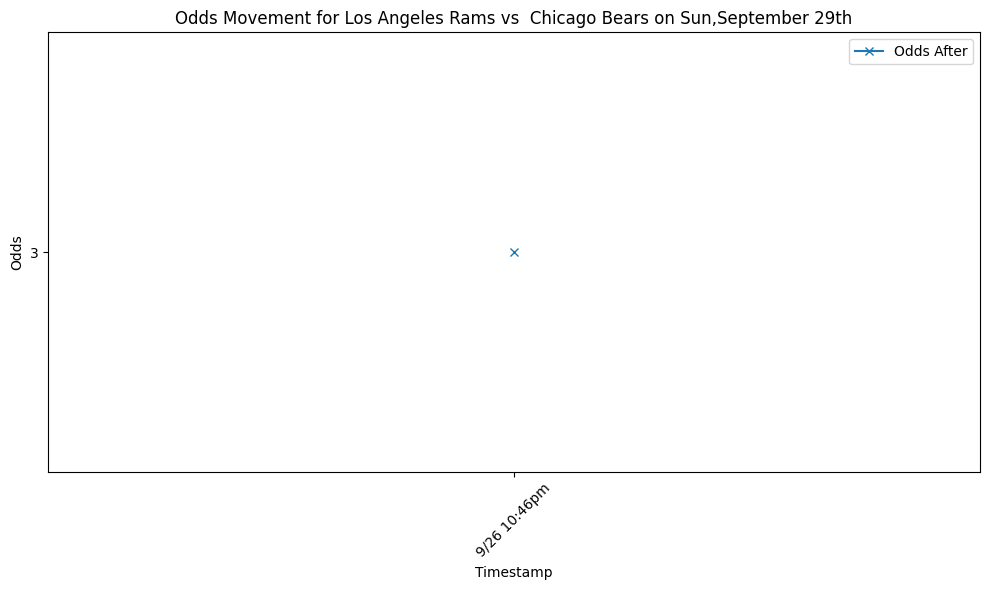

Timestamps for Los Angeles Rams vs  Chicago Bears on Sun,September 29th:
   timestamp
9/26 10:46pm



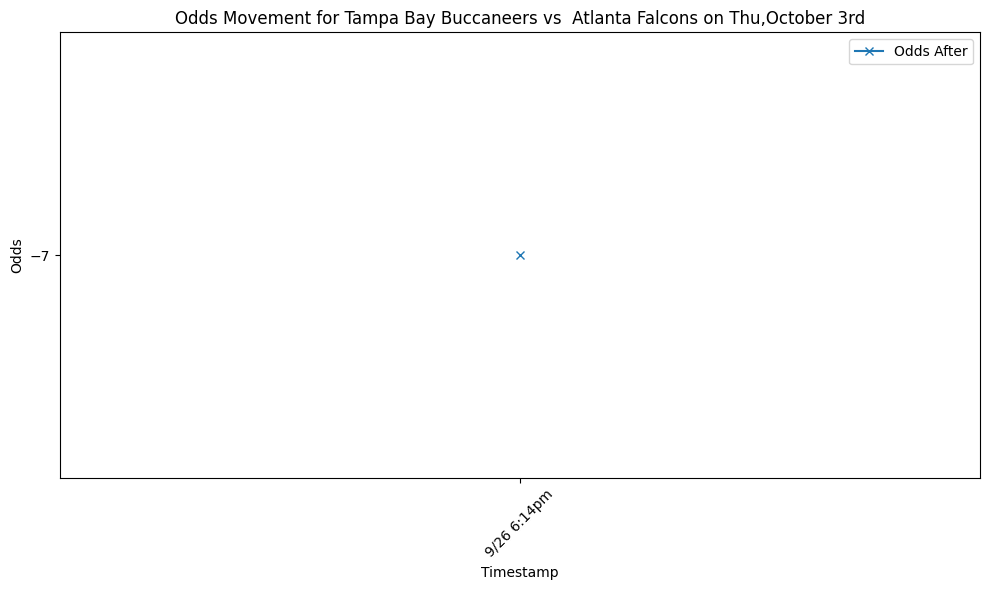

Timestamps for Tampa Bay Buccaneers vs  Atlanta Falcons on Thu,October 3rd:
  timestamp
9/26 6:14pm



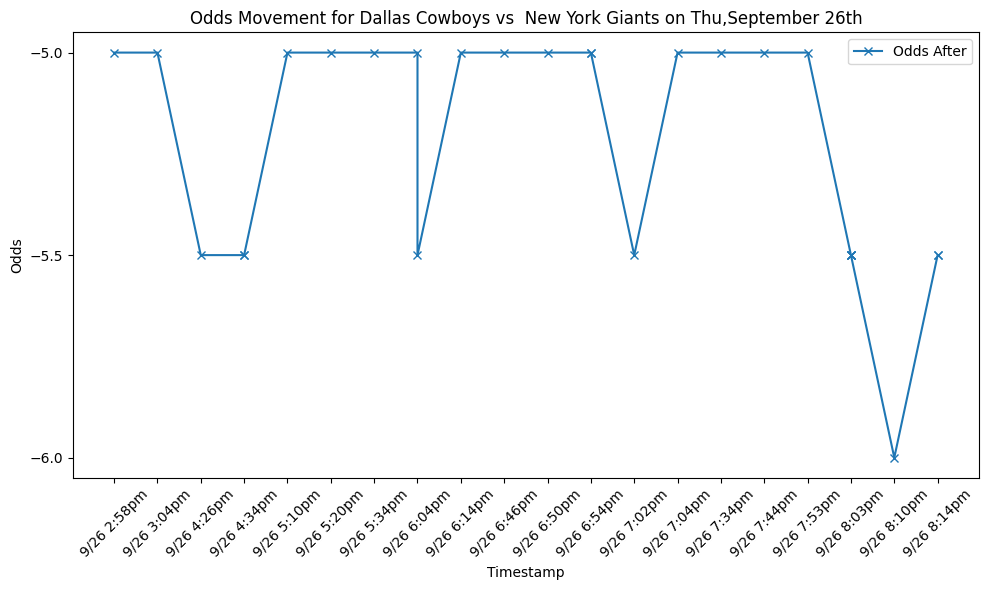

Timestamps for Dallas Cowboys vs  New York Giants on Thu,September 26th:
  timestamp
9/26 2:58pm
9/26 3:04pm
9/26 4:26pm
9/26 4:34pm
9/26 4:34pm
9/26 5:10pm
9/26 5:20pm
9/26 5:34pm
9/26 6:04pm
9/26 6:04pm
9/26 6:14pm
9/26 6:46pm
9/26 6:50pm
9/26 6:54pm
9/26 6:54pm
9/26 7:02pm
9/26 7:04pm
9/26 7:34pm
9/26 7:44pm
9/26 7:53pm
9/26 8:03pm
9/26 8:03pm
9/26 8:03pm
9/26 8:03pm
9/26 8:10pm
9/26 8:14pm
9/26 8:14pm



In [86]:
# Line charts

csv_file_path = 'data/odds_movements.csv'  # Adjust the path as needed
df = pd.read_csv(csv_file_path)
# df = df[df['sportsbook'] == 'Circa'] # ONLY CIRCA

unique_matchups = df[['matchup', 'game_date']].drop_duplicates()
unique_matchups = unique_matchups.sort_values(by='game_date')

df['timestamp'] = df['file2'].apply(
    lambda x: '_'.join(x.split('_')[3:5]).replace('.json', '')  # Modify as per the file2 structure
)

df['spread_before'] = pd.to_numeric(df['odds_before'].str.split(' ').str[0], errors='coerce')
df['spread_after'] = pd.to_numeric(df['odds_after'].str.split(' ').str[0], errors='coerce')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M', errors='coerce')  # Adjust the format if needed

for index, row in unique_matchups.iterrows():
    matchup = row['matchup']
    game_date = row['game_date']
    filtered_df = df[df['matchup'] == matchup].copy()
    filtered_df['timestamp'] = filtered_df['timestamp'].dt.strftime('%-m/%d %-I:%M%p').str.lower()
    # print(f"Timestamps for {matchup} on {game_date}:")
    # print(filtered_df[['timestamp']])
    # print('')
 
    # Check if there are any matching rows for the current matchup
    if filtered_df.empty:
        print(f"No data available for {matchup} on {game_date}")
    else:
        
        # Plot the line chart using 'timestamp' as x-axis and 'odds_before' and 'odds_after' as y-axes
        plt.figure(figsize=(10, 6))
        # plt.plot(filtered_df['timestamp'], filtered_df['odds_before'], label='Odds Before', marker='o')
        plt.plot(filtered_df['timestamp'], filtered_df['spread_after'], label='Odds After', marker='x')
        
        # Set the title and labels
        plt.title(f'Odds Movement for {matchup} on {game_date}')
        plt.xlabel('Timestamp')
        plt.ylabel('Odds')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        unique_spreads = sorted(filtered_df['spread_after'].dropna().unique())  # Get unique spread values
        plt.yticks(unique_spreads)  # Set these as the y-ticks
        plt.legend()
        plt.tight_layout()
        
        # Show the plot
        plt.show()

        # Print the timestamps as well for reference
        print(f"Timestamps for {matchup} on {game_date}:")
        print(filtered_df[['timestamp']].to_string(index=False))
        print('')  # Empty line for readability